In [26]:
import torch 
import os 
import sys
from collections import Counter
from torchvision import datasets, transforms
import copy
from tqdm import tqdm
from urllib import request
import zipfile
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler

# Add parent directory to path BEFORE importing from src
sys.path.insert(0, '..')

from torchinfo import summary 
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc
from src.model_builder import XceptionCustom  
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image
from torch.autograd import Variable
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from sklearn.linear_model import LinearRegression
import lime
from lime import lime_image
from skimage.io import imread
from src.dataloaders import *
from src.utils import *
import warnings
from scipy.spatial.distance import pdist, squareform
from sklearn.linear_model import Ridge
from pathlib import Path 
# Suppress all warnings
warnings.filterwarnings('ignore')

In [29]:
test_dir = Path('/home/nlfrx7981/uncertainty/data/polar-lows/test')
train_dir = Path('/home/nlfrx7981/uncertainty/data/polar-lows/train')

device = get_device('auto')
print(device)

cuda


In [30]:
train_transform, test_transform = get_transforms() 
train_loader, test_loader, n_pos_train, n_neg_train, class_to_idx_dict = create_dataloaders(train_dir=train_dir,
                                                                                test_dir=test_dir,
                                                                                train_transform=train_transform,
                                                                                test_transform=test_transform)
print(class_to_idx_dict)

# Load the best model weights
model = XceptionCustom(input_channels=3)
model.load_state_dict(torch.load('../src/outputs/20.08.25_polar_lows_customex.pth'))

# evaluate model 
y_pred_labels_np, y_true_np, y_pred_probs_np, misclassified_images, misclassified_true_labels, misclassified_pred_labels, misclassified_prob_vectors = evaluate_model(model, test_loader, device)

# Print classification report
print("\nClassification Report on Test Set:")
print(classification_report(y_true_np, y_pred_labels_np))
print(f"\nFound {len(misclassified_images)} misclassified images.")

Positive training samples: 254 (16%), Negative training samples: 1293 (83%)
{'neg': 0, 'pos': 1}

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       371
           1       0.92      0.95      0.94        64

    accuracy                           0.98       435
   macro avg       0.96      0.97      0.96       435
weighted avg       0.98      0.98      0.98       435


Found 8 misclassified images.


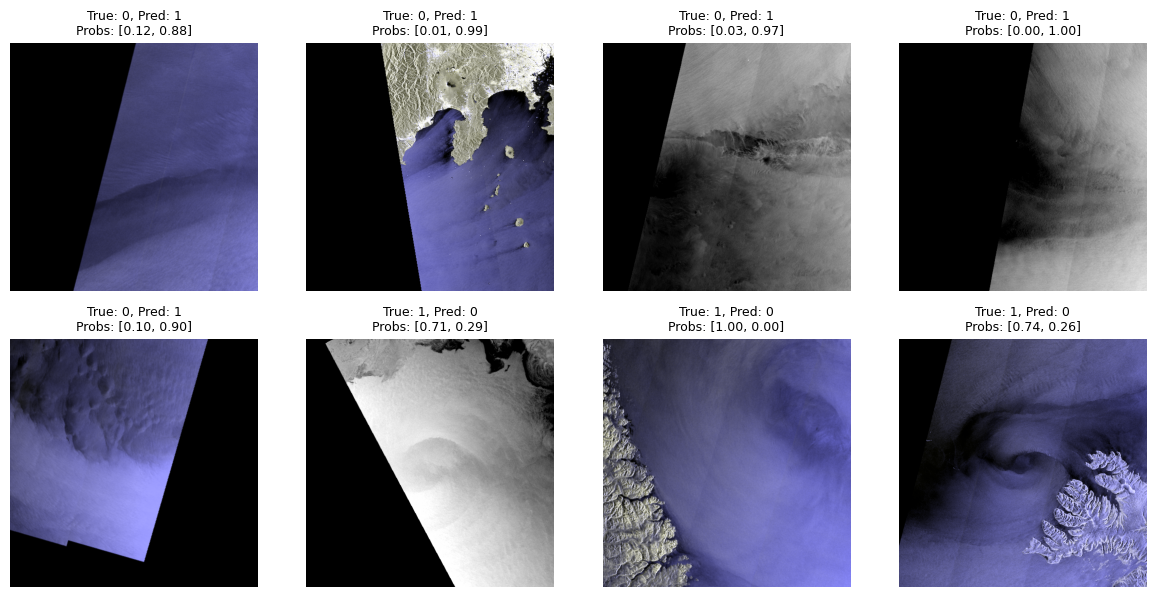

In [31]:
# --- plot misclassified images with probabilities ---
fig, axes = plt.subplots(4, 4, figsize=(12, 12)) # Create a 4x4 grid of subplots
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

for i in range(len(misclassified_images)):
    ax = axes[i]
    # Convert the image tensor (CHW) to NumPy array (HWC) for matplotlib
    img = misclassified_images[i].permute(1, 2, 0).numpy()
    ax.imshow(img)

    # Format the probability vector for display
    prob_vec = misclassified_prob_vectors[i].numpy()
    # Assuming two classes, e.g., [prob_neg, prob_pos]
    subtitle = f"True: {misclassified_true_labels[i]}, Pred: {misclassified_pred_labels[i]}\nProbs: [{prob_vec[0]:.2f}, {prob_vec[1]:.2f}]"
    ax.set_title(subtitle, fontsize=9) # Adjust fontsize as needed
    ax.axis('off') # Turn off the axes for each subplot

# Hide any unused subplots if fewer than 16 images are displayed
for j in range(len(misclassified_images), 16):
    fig.delaxes(axes[j])

plt.tight_layout() 
plt.show()

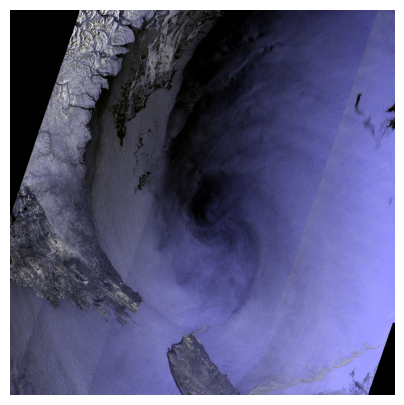

tensor([[1.5070e-06, 1.0000e+00]], device='cuda:0')


In [39]:
# fix particular instance for experiments
sample_img_path = test_dir/'pos'/'e8b0d4_20181231T025037_20181231T025219_mos_rgb.png'

plt.figure(figsize=(5, 5))  # Adjust width and height as needed
plt.imshow(get_image(sample_img_path))
plt.axis('off')
plt.show()

print(ImagePred(model, sample_img_path, test_transform, device)[1])

In [47]:
sample_img_tensor = test_transform(get_image(sample_img_path))
sample_img_tensor = sample_img_tensor.unsqueeze(0)  # Add batch dimension
model.eval()
logits_sample_img = model(sample_img_tensor.to(device))

Image shape: (800, 800, 3)
Image range: [0.000, 1.000]
Running LIME explanation...


100%|██████████| 1000/1000 [01:48<00:00,  9.24it/s]


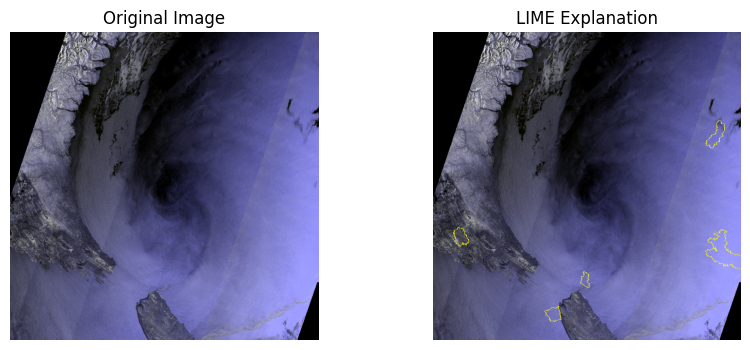

In [71]:
original_image = np.array(get_image(sample_img_path))
original_image = original_image / 255.0

print(f"Image shape: {original_image.shape}")
print(f"Image range: [{original_image.min():.3f}, {original_image.max():.3f}]")

def batch_predict(images):
    """Proper batch prediction for LIME"""
    model.eval()
    predictions = []
    
    with torch.no_grad():
        for img in images:
            # Convert numpy (from LIME) back to PIL (for transforms)
            if img.max() <= 1:
                pil_img = Image.fromarray((img * 255).astype(np.uint8))
            else:
                pil_img = Image.fromarray(img.astype(np.uint8))
            
            # Apply transforms and predict
            img_tensor = test_transform(pil_img).unsqueeze(0).to(device) # type:ignore 
            logits = model(img_tensor)
            probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
            predictions.append(probs)
    
    return np.array(predictions)



# Run LIME
print("Running LIME explanation...")
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    original_image,
    batch_predict,
    top_labels=10,
    hide_color=0,
    num_samples=1000
)
# Display results
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0], 
    positive_only=True, 
    num_features=5, 
    hide_rest=False
)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mark_boundaries(temp, mask))
plt.title('LIME Explanation')
plt.axis('off')
plt.show()